In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1,0"

In [2]:
import numpy as np
import pandas as pd
import os,cv2,gc
import pickle
from tqdm.notebook import tqdm
from collections import OrderedDict
import h5py
import random
import torch
from radam import Over9000
from sklearn.model_selection import KFold,StratifiedKFold
import tifffile
import timm
from torchvision import transforms
from sklearn import metrics
from fastai_fix import *
from torch.utils.data import Dataset, DataLoader
from scipy.stats import binned_statistic

In [3]:
OUT = 'init'
DATA = 'data/gwaves_clean_v5.pickle'
VAL = 'data/gwaves_train_v5.pickle'
VAL_LABELS = 'data/train_labels.csv'
TEST = '/media/iafoss/New Volume/ML/G2Net2022/data/test'

NUM_WORKERS = 12
nfolds = 4
SEED = 2022
bs = 128

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)
os.makedirs(OUT, exist_ok=True)

In [4]:
df = pd.read_csv(VAL_LABELS)
val_df = df.loc[df.target != -1].reset_index(drop=True)
with open(DATA, 'rb') as f: clean_data = pickle.load(f)
with open(VAL, 'rb') as f: val_data = pickle.load(f)

In [5]:
class G2NetDatasetTrain(Dataset):
    def __init__(self, data=clean_data, sz_f=352, sz_t=128, p=0.66, p_ns=0.5, depth0=15, depth1=50):
        self.data = data
        self.tfrms = transforms.Compose([
            transforms.RandomCrop((sz_f,sz_t)),
            #transforms.CenterCrop((sz_f,sz_t)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip()
        ])
        self.p,self.p_ns,self.sz_f,self.sz_t = p,p_ns,sz_f,sz_t
        self.depth0,self.depth1 = depth0,depth1
        
        #A_noise after multiplying by 1e22: very important parameter for model without norm
        #5e-2*np.sqrt(1800)/2 = 1.0606601717798214
        self.A_noise = 1.065
        Tsft = 1800
        self.tosqrtSX = 2/np.sqrt(Tsft)
        
        with open('data/real_noise_std.pickle', 'rb') as handle:
            self.std_est = pickle.load(handle)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        
        n_stat = [data['H1_ts'], data['L1_ts']]
        noise = [[] for source in range(len(n_stat))]
        if torch.rand(1).item() < 0.5: #nonstationary noise
            std_est = random.choice(self.std_est)
            A_noise = [
                np.where(std_est['H1_ts'] > 5 , std_est['H1_std'], self.A_noise*np.ones_like(std_est['H1_std'])),
                np.where(std_est['L1_ts'] > 5 , std_est['L1_std'], self.A_noise*np.ones_like(std_est['L1_std']))]
        else:
            A_noise = self.A_noise*np.ones((2,self.sz_t))
        for source in range(len(n_stat)):
            for n in n_stat[source]:
                if n == 0:
                    noise[source].append(torch.zeros(self.sz_f))
                    continue
                dist = torch.distributions.chi2.Chi2(2*n) #2 because real+img
                sample = dist.sample((self.sz_f,))/n
                sample *= A_noise[source][n]*A_noise[source][n]
                noise[source].append(sample)
        noise = torch.stack([torch.stack(noise[0],-1),torch.stack(noise[1],-1)],0)
        
        if torch.rand(1).item() < self.p: #positive sample
            target = 1
            x0 = torch.from_numpy(np.stack([data['H1'],data['L1']],0).astype(np.float32))
            c,h,w = x0.shape
            noise = noise.repeat(1,2,1)[:,:h,:]
            x0 = torch.cat([x0,noise],0)[:,20:-20]
            x0 = self.tfrms(x0) #transform noise and signal togather
            
            depth = self.depth0 + (self.depth1-self.depth0)*torch.rand(1)
            #print(depth)
            scale = 1e2*self.A_noise*self.tosqrtSX #noise-free data is generated at h=1e-2
            x = x0[c:] + x0[:c]*scale**2/depth**2 #noise + signal
            
            if target == 1: raw = x0[:c]/x0[:c].max()*(self.depth1-depth)/(self.depth1-self.depth0)
            else: raw = torch.zeros_like(x)
        else:
            target = 0
            x = self.tfrms(noise)
            raw = torch.zeros_like(x)
            
        x[0] /= torch.max(x[0].mean(0,keepdim=True),0.1*torch.ones_like(x[0]))
        x[1] /= torch.max(x[1].mean(0,keepdim=True),0.1*torch.ones_like(x[1]))
        
        x = torch.cat([x,0.5*(x[0]+x[1]).unsqueeze(0)],0)
        raw = torch.cat([raw,0.5*(raw[0]+raw[1]).unsqueeze(0)],0)
        
        return {'x':x},{'y':target,'mask':raw}
    
class G2NetDatasetVal(Dataset):
    def __init__(self, data=val_data, df=val_df, sz_f=352, sz_t=128, tta=4, gen_noise=False):
        self.df = df
        self.data = data
        self.sz_t, self.sz_f = sz_t,sz_f
        self.tfrms = transforms.CenterCrop((sz_f,sz_t))
        self.tta = tta
        
        self.gen_noise = False
        self.A_noise = 1.065 #after multiplying by 1e22 [very important parameter] 1.0609313
        Tsft = 1800
        self.tosqrtSX = 2/np.sqrt(Tsft)
        
    def __len__(self):
        return self.tta*len(self.df)

    def __getitem__(self, idx):
        tta = (idx // len(self.df))%4
        idx,target = self.df.loc[idx%len(self.df),['id','target']]
        data = self.data[idx]
        x = torch.from_numpy(np.stack([data['H1'],data['L1']],0).astype(np.float32))
        x = self.tfrms(x)
        c,h,w = x.shape
        x[0] /= torch.max(x[0].mean(0,keepdim=True),0.1*torch.ones_like(x[0]))
        x[1] /= torch.max(x[1].mean(0,keepdim=True),0.1*torch.ones_like(x[1]))
        x = torch.cat([x,0.5*(x[0]+x[1]).unsqueeze(0)],0)
        
        if self.gen_noise and target == 0:
            n_stat = [data['H1_ts'], data['L1_ts']]
            noise = [[] for source in range(len(n_stat))]
            A_noise = self.A_noise*np.ones((2,self.sz_t))
            for source in range(len(n_stat)):
                for n in n_stat[source]:
                    if n == 0:
                        noise[source].append(torch.zeros(self.sz_f))
                        continue
                    dist = torch.distributions.chi2.Chi2(2*n) #2 because real+img
                    sample = dist.sample((self.sz_f,))/n
                    sample *= A_noise[source][n]*A_noise[source][n]#*s
                    noise[source].append(sample)
            x = torch.stack([torch.stack(noise[0],-1),torch.stack(noise[1],-1)],0)
            c,h,w = x.shape
            x[0] /= torch.max(x[0].mean(0,keepdim=True),0.1*torch.ones_like(x[0]))
            x[1] /= torch.max(x[1].mean(0,keepdim=True),0.1*torch.ones_like(x[1]))
            x = torch.cat([x,0.5*(x[0]+x[1]).unsqueeze(0)],0)

        if tta == 1: x = x.flip(-1)
        elif tta == 2: x = x.flip(-2)
        elif tta == 3: x = x.flip(-1,-2)
        return {'x':x},{'y':target}
    
def extract_data_from_hdf5(path):
    data = {}
    with h5py.File(path, "r") as f:
        ID_key = list(f.keys())[0]
        # Retrieve the frequency data
        data['freq'] = np.array(f[ID_key]['frequency_Hz'])
        # Retrieve the Livingston decector data
        data['L1_SFTs_amplitudes'] = np.array(f[ID_key]['L1']['SFTs'])
        data['L1_ts'] = np.array(f[ID_key]['L1']['timestamps_GPS'])
        # Retrieve the Hanford decector data
        data['H1_SFTs_amplitudes'] = np.array(f[ID_key]['H1']['SFTs'])
        data['H1_ts'] = np.array(f[ID_key]['H1']['timestamps_GPS'])
    return data
        
class G2NetDataset_hdf5(Dataset):
    def __init__(self, path=TEST, sz_f=352, sz_t=128):
        self.files = [os.path.join(path,f) for f in os.listdir(path) if f.split('.')[-1] == 'hdf5']
        self.sz_t, self.sz_f = sz_t,sz_f
        self.tfrms = transforms.CenterCrop((sz_f,sz_t))
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = extract_data_from_hdf5(self.files[idx])
        time_ids = {'H1':data['H1_ts'], 'L1':data['L1_ts']}
    
        mean_statH = binned_statistic(time_ids['H1'], np.abs(data['H1_SFTs_amplitudes']*1e22)**2,
            statistic='mean', bins=self.sz_t, 
            range=(max(time_ids['H1'].min(),time_ids['L1'].min()),
            min(time_ids['H1'].max(),time_ids['L1'].max())))
        mean_statL = binned_statistic(time_ids['L1'], np.abs(data['L1_SFTs_amplitudes']*1e22)**2,
            statistic='mean', bins=self.sz_t, 
            range=(max(time_ids['H1'].min(),time_ids['L1'].min()),
            min(time_ids['H1'].max(),time_ids['L1'].max())))
        mean_statH = np.nan_to_num(np.transpose(mean_statH.statistic,(0,1)))
        mean_statL = np.nan_to_num(np.transpose(mean_statL.statistic,(0,1)))

        n_statH = binned_statistic(time_ids['H1'], np.ones((1,len(time_ids['H1']))), statistic='sum',
            bins=self.sz_t, range=(max(time_ids['H1'].min(),time_ids['L1'].min()),
            min(time_ids['H1'].max(),time_ids['L1'].max())))
        n_statL = binned_statistic(time_ids['L1'], np.ones((1,len(time_ids['L1']))), statistic='sum',
            bins=self.sz_t, range=(max(time_ids['H1'].min(),time_ids['L1'].min()),
            min(time_ids['H1'].max(),time_ids['L1'].max())))
        n_statH = np.nan_to_num(n_statH.statistic)[0].astype(int)
        n_statL = np.nan_to_num(n_statL.statistic)[0].astype(int)
        
        x = torch.from_numpy(np.stack([mean_statH,mean_statL],0).astype(np.float32))
        x = self.tfrms(x)
        c,h,w = x.shape
        
        x[0] /= torch.max(x[0].mean(0,keepdim=True),0.1*torch.ones_like(x[0]))
        x[1] /= torch.max(x[1].mean(0,keepdim=True),0.1*torch.ones_like(x[1]))
        
        x = torch.cat([x,0.5*(x[0]+x[1]).unsqueeze(0)],0)

        idx = self.files[idx].split('/')[-1].split('.')[0]
        return {'x':x},{'y':idx}

1


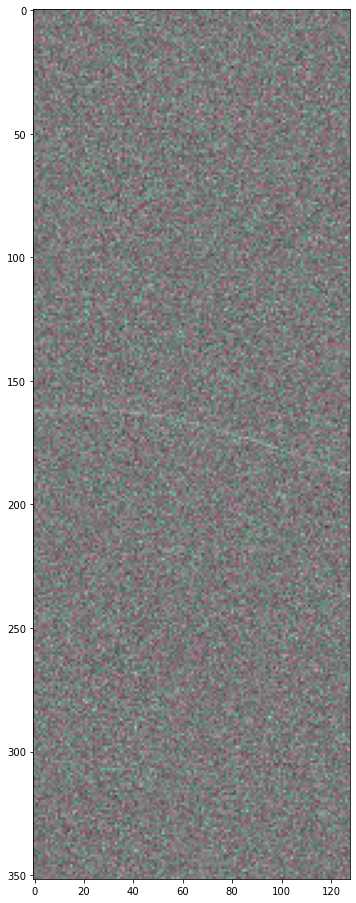

In [12]:
ds = G2NetDatasetTrain(p=1, depth0=10, depth1=20)
x,y = ds[2]
print(y['y'])
plt.figure(figsize=(16, 16))
plt.imshow(x['x'].permute(1,2,0)/x['x'].max())

In [6]:
from segformer_head import *
from segformer import PixelShuffle_ICNR

class Model(nn.Module):
    def __init__(self, n=1, arch='resnext50_32x4d_ssl', 
                 path='facebookresearch/semi-supervised-ImageNet1K-models', ps=0.5):
        super().__init__()
        m = torch.hub.load(path, arch)
        nc = list(m.children())[-1].in_features
        self.enc = nn.Sequential(*list(m.children())[:-2])

        nh = 2048
        self.head = nn.Sequential(AdaptiveConcatPool2d(1),Flatten(),nn.Dropout(ps),
                                  nn.BatchNorm1d(2*nh),nn.Dropout(ps/2),nn.Linear(2*nh,512),nn.ReLU(inplace=True),
                                  nn.BatchNorm1d(512),nn.Dropout(ps),nn.Linear(512,n))
        
    def forward(self, x):
        x = x['x']
        x = self.head(self.enc(x))
        return {'p':x}
        
    split_layers = lambda m: [list(m.module.enc.parameters()), list(m.module.head.parameters())]
    
class Model_SegH0(nn.Module):
    def __init__(self, ps=0.5, n=1):
        super().__init__()
        m = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', 'resnext50_32x4d_ssl')
        self.enc0 = nn.Sequential(m.conv1, m.bn1, nn.ReLU(inplace=True))
        self.enc1 = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1),m.layer1) #256
        self.enc2 = m.layer2 #512
        self.enc3 = m.layer3 #1024
        self.enc4 = m.layer4 #2048
        self.decode_head = SegFormerHead(feature_strides=[4, 8, 16, 32],
                            in_channels=[256, 512, 1024, 2048],embedding_dim=128)
        self.final_conv = nn.Sequential(
            PixelShuffle_ICNR(self.decode_head.embedding_dim,self.decode_head.embedding_dim//4, blur=False),
            nn.Dropout2d(0.1), nn.Conv2d(self.decode_head.embedding_dim//4, 3, 3, padding=1))
        self.up_result=2
        nh = 2048
        self.head = nn.Sequential(AdaptiveConcatPool2d(1),Flatten(),nn.Dropout(ps),#nn.Linear(2*nh,512),
                                  nn.BatchNorm1d(2*nh),nn.Dropout(ps/2),nn.Linear(2*nh,512),nn.ReLU(inplace=True),
                                  nn.BatchNorm1d(512),nn.Dropout(ps),nn.Linear(512,n))
        
    def forward(self, x):
        x = x['x']
        x = self.enc0(x)
        x0 = self.enc1(x)
        x1 = self.enc2(x0)
        x2 = self.enc3(x1)
        x3 = self.enc4(x2)
        p = self.head(x3)
        if self.training:
            x = self.decode_head([x0,x1,x2,x3])
            x = F.interpolate(self.final_conv(x),scale_factor=self.up_result,mode='bilinear',align_corners=False)
            return {'p':p, 'mask':x}
        else: return {'p':p}
    
    split_layers = lambda m: [list(m.module.enc0.parameters()) + list(m.module.enc1.parameters()) + \
                              list(m.module.enc2.parameters()) + list(m.module.enc3.parameters()) + \
                              list(m.module.enc4.parameters()),
                              list(m.module.decode_head.parameters()) + list(m.module.final_conv.parameters()) + \
                              list(m.module.head.parameters())]
    
class Model_SegH(nn.Module):
    def __init__(self, arch='tf_efficientnet_b4_ns', ps=0.5, n=1):
        super().__init__()
        self.enc = timm.create_model(arch,features_only=True, pretrained=True)
        self.decode_head = SegFormerHead(feature_strides=[4, 8, 16, 32],
                            in_channels=self.enc.feature_info.channels()[-4:],embedding_dim=128)
        self.final_conv = nn.Sequential(
            PixelShuffle_ICNR(self.decode_head.embedding_dim,self.decode_head.embedding_dim//4, blur=False),
            nn.Dropout2d(0.1), nn.Conv2d(self.decode_head.embedding_dim//4, 3, 3, padding=1))
        self.up_result=2
        nh = self.enc.feature_info.channels()[-1]
        self.head = nn.Sequential(AdaptiveConcatPool2d(1),Flatten(),nn.Dropout(ps),
                                  nn.BatchNorm1d(2*nh),nn.Dropout(ps/2),nn.Linear(2*nh,512),nn.ReLU(inplace=True),
                                  nn.BatchNorm1d(512),nn.Dropout(ps),nn.Linear(512,n))
    def forward(self, x):
        encs = self.enc(x['x'])[-4:]
        p = self.head(encs[-1])
        if self.training:
            x = self.decode_head(encs)
            x = F.interpolate(self.final_conv(x),scale_factor=self.up_result,mode='bilinear',align_corners=False)
            return {'p':p, 'mask':x}
        else: return {'p':p}
    
    split_layers = lambda m: [list(m.module.enc.parameters()),
                              list(m.module.decode_head.parameters()) + list(m.module.final_conv.parameters()) + \
                              list(m.module.head.parameters())]

In [7]:
from sklearn.metrics import roc_auc_score
class AUC(Metric):
    def __init__(self, tta=4):
        super().__init__()
        self.preds = []
        self.targets = []
        self.tta = tta
        
    def reset(self): 
        self.preds = []
        self.targets = []
        
    def accumulate(self,learn):
        self.preds.append(torch.nan_to_num(learn.pred['p'].cpu()))
        self.targets.append(learn.y['y'].cpu())
    
    @property
    def value(self):
        p = torch.cat(self.preds,0)
        t = torch.cat(self.targets,0)
        p = p.view(self.tta,-1).mean(0)
        t = t[:t.shape[0]//self.tta]
        return roc_auc_score(t, p)
    
def Loss(x,y):
    loss_c = F.binary_cross_entropy_with_logits(torch.nan_to_num(x['p']).view(-1),y['y'].view(-1).float())
    loss_s = F.binary_cross_entropy_with_logits( \
        torch.nan_to_num(x['mask'].view(-1).float()), y['mask'].view(-1).float()) \
        if 'mask' in x and 'mask' in y else 0
    return loss_c + loss_s

def Loss_c(x,y):
    return F.binary_cross_entropy_with_logits(x['p'].view(-1),y['y'].view(-1).float())

from radam import Over9000,Lookahead
def WrapperOver9000(param_groups,**kwargs):
    return OptimWrapper(param_groups,Over9000) 

from madgrad import MADGRAD
def WrapperMADGRAD(param_groups,**kwargs):
    return OptimWrapper(param_groups,MADGRAD)

In [8]:
#resnext50
fname = 'model_v5_0_tmp'

ds_t = G2NetDatasetTrain()
ds_v = G2NetDatasetVal()
data = ImageDataLoaders.from_dsets(ds_t,ds_v,bs=192,num_workers=NUM_WORKERS, persistent_workers=True).cuda()

M = Model_SegH0
model = M()
model = nn.DataParallel(model.cuda())

learn = Learner(data, model, loss_func=Loss,
                metrics=[AUC()],
                opt_func=partial(WrapperOver9000,eps=1e-4),
                cbs=[GradientClip()],
                splitter=M.split_layers).to_fp16()
  
#learn.fit_one_cycle(1, lr_max=(0.5e-3,5e-3), wd=1e-3)
learn.fit_one_cycle(192, lr_max=(5e-4,5e-3), pct_start=1/192, wd=[1e-3,1e-2])
torch.save(learn.model.module.state_dict(),os.path.join(OUT,f'{fname}_0.pth'))

Using cache found in /home/iafoss/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


epoch,train_loss,valid_loss,auc,time
0,1.139925,0.574417,0.774850,03:03


/host/Users/Iafoss/Documents/Jupyter/G2Net2022/radam.py:574: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1174.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


In [11]:
#eval
fname = 'model_v5_0_tmp'

ds_t = G2NetDatasetTrain()
ds_v = G2NetDatasetVal(tta=4)
data = ImageDataLoaders.from_dsets(ds_t,ds_v,bs=192,num_workers=NUM_WORKERS, persistent_workers=True).cuda()

M = Model_SegH0
model = M()

model.load_state_dict(torch.load(os.path.join(OUT,f'{fname}_0.pth')))
model = nn.DataParallel(model.cuda())

learn = Learner(data, model, loss_func=Loss, metrics=[AUC(tta=4)],).to_fp16()
learn.validate()

Using cache found in /home/iafoss/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


(#2) [0.5744171738624573,0.77485]

In [11]:
#Test data
fnames = ['model_v5_0_8_0.pth','model_v5_0_8_0c.pth']
ds = G2NetDataset_hdf5()
dl = DataLoader(ds,batch_size=128,num_workers=4,shuffle=False,drop_last=False)
models = []
for fname in fnames:
    model = Model_SegH()
    model.load_state_dict(torch.load(os.path.join(OUT,fname)))
    model = nn.DataParallel(model.cuda())
    model.eval();
    models.append(model)

preds,ids = [[] for _ in range(len(fnames))],[]
for x,y in tqdm(dl):
    x = x['x'].cuda()
    for i,model in enumerate(models):
        with torch.no_grad():
            with torch.cuda.amp.autocast(enabled=True):
                p = torch.stack([model({'x':x})['p'], model({'x':x.flip(-1)})['p'], 
                                 model({'x':x.flip(-2)})['p'], model({'x':x.flip(-1,-2)})['p']],0)
                p = torch.sigmoid(torch.nan_to_num(p)).mean(0).cpu()
        preds[i].append(p)
    ids.append(y['y'])
preds = [torch.cat(pred,0).view(-1).float() for pred in preds]
ids = np.concatenate(ids)

for pred,fname in zip(preds,fnames):
    fname = fname.split('.')[0]
    df_test = pd.DataFrame({'id':ids,'target':pred.numpy()})
    df_test.to_csv(os.path.join(OUT,f'submission_{fname}.csv'),index=False)
df_test.head()

Using cache found in /home/iafoss/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master
Using cache found in /home/iafoss/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


  0%|          | 0/63 [00:00<?, ?it/s]

,id,target
0,00054c878,0.428223
1,0007285a3,0.960449
2,00076c5a6,0.374023
3,001349290,0.498535
4,001a52e92,0.788086


<AxesSubplot:>

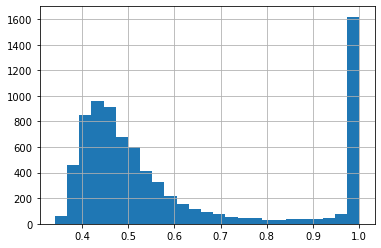

In [12]:
df_test['target'].hist(bins=25)

<AxesSubplot:>

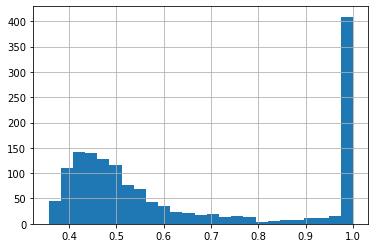

In [13]:
df_test_std = pd.read_csv('data/test_std.csv')
df_test['target'][df_test_std.std_flag > 0].hist(bins=25)

<AxesSubplot:>

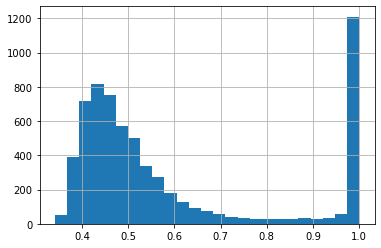

In [14]:
df_test_std = pd.read_csv('data/test_std.csv')
df_test['target'][df_test_std.std_flag == 0].hist(bins=25)